In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Region simulation tutorial


This tutorial presents the basic anatomy of a region simulation using The Virtual Brain's (TVB's) scripting interface. 

A script implementing the basic simulation described below can be found in tvb.simulator.demos

The first thing we want to do is import the modules we'll need for a simulation. A basic simulation consists of five main components, each of these components is an object within TVB:

1. *Model*, which is, at its core, a set of differential equations describing the local neuronal dynamics;
2. *Connectivity*, represents the large scale structural connectivity of the brain, ie white-matter tracts;
3. *Coupling*, is a function that is used to join the local *Model* dynamics at distinct locations over the connections described in *Connectivity*;
4. *Integrator*, is the integration scheme that will be applied to the coupled set of differential equations;
5. *Monitors*, one or more Monitors can be attached to a simulation, they act to record the output from the *Simulator*.

All of these components are brought together in a *Simulator* object, which is then used to run a simulation.

Hopefully this will make more sense with an explicit example.

NOTE: If you're working from a static web page, pasting the commands from this page into an ipython terminal should work. Alternatively, this tutorial is available as an ipython notebook, in that case the code is evaluated by selecting the cell containing it and pressing shift-enter. Also, when the code is evaluated, TVB's internal logging mechanisms produce output describing when/where/what of the operation, this is the text you'll see below the code cells. 

Setup
-----

Let's begin by importing the the modules we'll need, this is most easily achieved with:

In [2]:
from tvb.simulator.lab import *

   INFO  log level set to INFO
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wilson_cowan.WilsonCowan.state_variable_range = Const(field_type=<type 'dict'>, default={'I': array([0., 1.]), 'E': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Const(field_type=<type 'dict'>, default={'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.]), 'xi': array([-4.,  4.]), 'eta': array([-3.,  3.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.state_variable_range = Const(field_type=<type 'dict'>, default={'tau': array([ 2., 10.]), 'xi': array([-4.,  4.]), 'beta': array([-20.,  20.]), 'eta': arra

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.hopfield.Hopfield.state_variable_range = Const(field_type=<type 'dict'>, default={'x': array([-1.,  2.]), 'theta': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Const(field_type=<type 'dict'>, default={'y2': array([0., 2.]), 'g': array([-1.,  1.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y1': array([-20.,   2.]), 'x1': array([-2.,  1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Const(field_type=<type 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING  default contains values out of the declared domain. 

//anaconda/envs/tvb_library_git/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


*Model*
--------

Having imported the necessary components of TVB we now need to create specific instances that we'll use in our simulation. Most of the scientific Modules of TVB are setup with "sensible" defaults, and we'll be taking advantage of this here by not bothering to explicitly set very many of the configurable parameters -- and there are a lot of them, the flexibility of TVB is one of its strengths.

Let's start with the Model for the local dynamics we wish to use, there are a number of predefined Models available in TVB, as an example here we'll use a generic 2 dimensional oscillator with its default parameters:

In [3]:
oscilator = models.Generic2dOscillator()

*Connectivity*
---------------

We now need define some structure for our simple oscillator model to run on, again we'll rely on TVB's defaults, calling Connectivity without arguments leads to a default connectivity dataset being loaded. Having loaded the default dataset we can then alter the speed of signal propagation through the network to 4.0 ms$^{-1}$: 

In [4]:
white_matter = connectivity.Connectivity.from_file()
white_matter.speed = numpy.array([4.0])

WARNING  File 'hemispheres' not found in ZIP.


*Coupling*
-----------

The next step is to define a coupling function, proper setting of the parameters for this function requires some knowledge of the properties of both the Model being used and the structure through which it is connected. For our present purposes, we happen to know that for the default parameters of TVB's Generic2dOscillator connected through TVB's default connectivity matrix, a linear function with a slope of 0.0154 is a reasonable thing to use.

NOTE: here we are setting a non-default parameter via an argument to the definition of our coupling. 

In [5]:
white_matter_coupling = coupling.Linear(a=numpy.array([0.0154]))

*Integrator*
-------------

Now that we've defined our structure and dynamics we need to select an integration scheme. While TVB supports a number of schemes, for most purposes you should use either HeunDeterministic or HeunStochastic.

To keep things simple, we'll use HeunDeterministic with an integration step size of 2$^{-6}$ -- because powers of 2 are nice. The most important thing here is to use a step size that is small enough for the integration to be numerically stable, ideally the number chosen should also be machine representable ().

In [6]:
heunint = integrators.HeunDeterministic(dt=2**-6)

*Monitors*
-----------

The last component we need to define are some Monitors. The important thing to know here is that TVB doesn't support interpolation of the time-series it produces, which means that the period given to a monitor must be an integral multiple of the dt selected for the integration scheme. 

Although there are Monitors which apply a biophysical measurement process to the simulated neural activity, such as EEG, MEG, etc, here we'll select two simple monitors just to show the idea.

The Raw Monitor takes no arguments and simply returns all the simulated data -- note: as a general rule this shouldn't be used for anything but very short simulations as the amount of data returned can become prohibitively large.

The TemporalAverage Monitor averages over a time window of length *period* returning one time point every *period* ms. It also, by default, only returns those state-variables flagged in the Models definition as *variables_of_interest*.

Having defined a couple of Monitors, we put them in a tuple in order to pass them to the Simulator.

In [7]:
#Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=2**-2)

#Bundle them
what_to_watch = (mon_raw, mon_tavg)

*Simulator*
------------

The next step is to bring all these components together into a Simulator object. We then need to run the configure method, which basically just acts to calculate information necessary for the simulation that draws on specific combinations of the components.  

In [8]:
#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = oscilator, connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, monitors = what_to_watch)

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 23b40c29-a51a-4943-af05-61e11adb6044
coupling,Linear gid: 1b9e7304-1d78-4ca0-88ec-85da45a397c2
gid,UUID('62d79651-8f12-4bbb-b562-d6f8ef844a96')
initial_conditions,None
integrator,HeunDeterministic gid: abe19f71-9374-49e1-9671-88a9f0d53db3
model,Generic2dOscillator gid: 89b2da46-12ab-43f1-9657-e2eec3f28b2d
monitors,"(, )"
simulation_length,1000.0


Running a simulation
----------------------

Now finally, we can run the simulation. The simulator that we've created is an iterable object, so all we need to do is iterate for some length, which we provide in ms, and collect the output: 

In [9]:
#Perform the simulation
raw_data = []
raw_time = []
tavg_data = []
tavg_time = []

for raw, tavg in sim(simulation_length=2**10):
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

Taking a look at the results
------------------------------

The data returned by the simulator is in the form of a list of arrays. For most subsequent purposes it is much easier to deal with the data if it exists as a single contiguous array. And so we'll do that now:

In [10]:
#Make the lists numpy.arrays for easier use.
RAW = numpy.array(raw_data)
TAVG = numpy.array(tavg_data)

Importing tvb.simulator.lab above also imported the plotting functionality of matplotlib.pyplot, which we'll now use to take a rough first look at our simulated data:

<IPython.core.display.Javascript object>


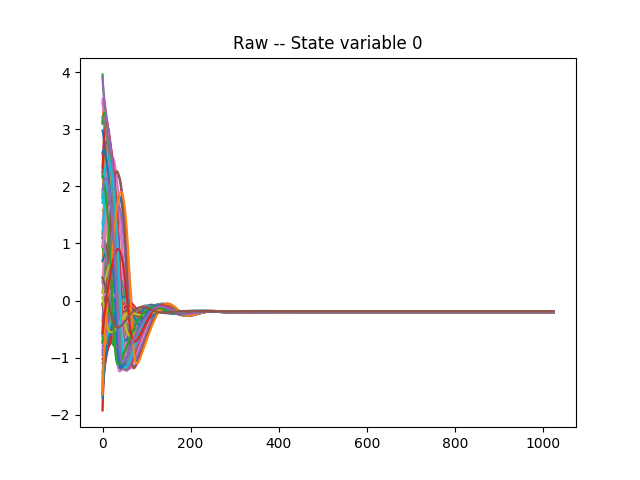

<IPython.core.display.Javascript object>


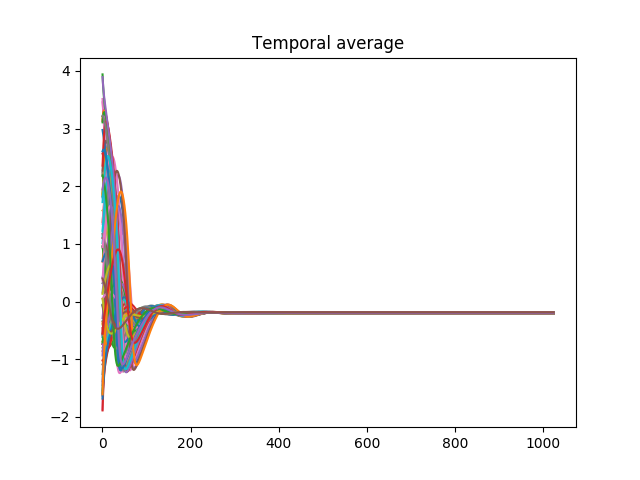

In [11]:
#Plot raw time series
figure(1)
plot(raw_time, RAW[:, 0, :, 0])
title("Raw -- State variable 0")

#Plot temporally averaged time series
figure(2)
plot(tavg_time, TAVG[:, 0, :, 0])
title("Temporal average")

#Show them
show()

The transient large amplitude oscillatory activity at the beginning of the simulation is a result of the imperfectly set initial conditions -- they are merely set by default to be random walks within the general range of state-variable values expected from the model. As the current simulation is configured with fixed point dynamics, if we were to set the initial conditions exactly to the values corresponding to that fixed point there would be no such initial transient.  

That's all folks -- so, what now?
---------------------------------

And that's it for this tutorial, while it's not a particularly scientifically interesting simulation hopefully it gave you a sense of the anatomy of a simulation within TVB. If you're interested in more detail behind what we've done here, the best place to go next is probably TVB's hand-book.

Alternatively, if you feel you have a good idea of the basics, you might want to move on to one of the more advanced tutorials describing surface simulations, stimuli, and biophysical Monitors (eg EEG).